In [1]:
# import necessary libraries
import os, random, numpy as np, torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [3]:
def get_device():
    if torch.cuda.is_available(): return torch.device("cuda")
    return torch.device("cpu")

In [4]:
def count_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [5]:
# CIFAR10 data
def get_cifar10_loaders(data_dir="./data", batch=128, workers=2):
    # Standard CIFAR-10 stats (or compute if you prefer)
    mean=(0.4914,0.4822,0.4465); std=(0.2023,0.1994,0.2010)
    tf = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True,  download=True, transform=tf)
    test_set  = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=tf)
    train_loader = DataLoader(train_set, batch_size=batch, shuffle=True,  num_workers=workers, pin_memory=True)
    test_loader  = DataLoader(test_set,  batch_size=batch, shuffle=False, num_workers=workers, pin_memory=True)
    return train_loader, test_loader

In [6]:
# model family of CNN
class CNN(nn.Module):
    """
    Base stages: [16, 32, 64] channels; scaled by 'w' (float multiplier).
    """
    def __init__(self, num_classes=10, width_mult: float = 1.0):
        super().__init__()
        c1 = max(8, int(16 * width_mult))
        c2 = max(8, int(32 * width_mult))
        c3 = max(16, int(64 * width_mult))
        self.features = nn.Sequential(
            nn.Conv2d(3, c1, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(c1, c1, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                        # c1 x 16 x 16
            nn.Conv2d(c1, c2, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(c2, c2, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),                        # c2 x 8 x 8
            nn.Conv2d(c2, c3, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(c3, c3, 3, padding=1), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1)),           # c3 x 1 x 1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(c3, num_classes)
        )
    def forward(self, x): return self.classifier(self.features(x))

In [7]:
# Train and test
def train_one_epoch(model, loader, opt, loss_fn, device):
    model.train()
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        opt.step()
        tot_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, correct/tot

@torch.no_grad()
def evaluate(model, loader, loss_fn, device):
    model.eval()
    tot_loss, tot, correct = 0.0, 0, 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        tot_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        tot += xb.size(0)
    return tot_loss/tot, correct/tot

In [8]:
def main(width_list=None, epochs=10, lr=1e-3, weight_decay=0.0,
                          batch=128, data_dir="./data", out_dir="HW_1-3_ParamVsGen"):
    """
    Trains the same CNN with different width multipliers; logs train/test loss & acc,
    and plots them vs number of parameters.
    """
    if width_list is None:
        # 10 models
        width_list = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0, 4.0]

    os.makedirs(out_dir, exist_ok=True)
    set_seed(42)
    dev = get_device()
    train_loader, test_loader = get_cifar10_loaders(data_dir=data_dir, batch=batch)

    # storage
    param_counts = []
    train_losses = []; test_losses = []
    train_accs   = []; test_accs   = []

    for w in width_list:
        model = CNN(width_mult=w).to(dev)
        params = count_parameters(model)
        param_counts.append(params)

        opt = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        loss_fn = nn.CrossEntropyLoss()

        # train
        for ep in range(1, epochs+1):
            tr_loss, tr_acc = train_one_epoch(model, train_loader, opt, loss_fn, dev)
        # evaluate after final epoch
        te_loss, te_acc = evaluate(model, test_loader, loss_fn, dev)

        train_losses.append(tr_loss); test_losses.append(te_loss)
        train_accs.append(tr_acc);   test_accs.append(te_acc)

        print(f"w={w:>4} | params={params:>8,d} | "
              f"train loss {tr_loss:.3f} acc {tr_acc*100:5.1f}% | "
              f"test loss {te_loss:.3f} acc {te_acc*100:5.1f}%")

    # Loss vs #params plot
    plt.figure(figsize=(9,4.8))
    plt.scatter(param_counts, train_losses, label="train_loss")
    plt.scatter(param_counts, test_losses,  label="test_loss")
    plt.xlabel("number of parameters"); plt.ylabel("loss"); plt.title("model loss")
    plt.grid(True, linewidth=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(out_dir, "loss_vs_params.png"), dpi=180); plt.show(); plt.close()

    # Accuracy vs #params loss
    plt.figure(figsize=(9,4.8))
    plt.scatter(param_counts, train_accs, label="train_acc")
    plt.scatter(param_counts, test_accs,  label="test_acc")
    plt.xlabel("number of parameters"); plt.ylabel("accuracy"); plt.title("model accuracy")
    plt.grid(True, linewidth=0.3); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(out_dir, "acc_vs_params.png"), dpi=180); plt.show(); plt.close()

    return {
        "params": param_counts,
        "train_loss": train_losses, "test_loss": test_losses,
        "train_acc": train_accs,   "test_acc": test_accs
    }

Files already downloaded and verified
Files already downloaded and verified
w= 0.5 | params=  18,514 | train loss 1.165 acc  58.0% | test loss 1.177 acc  57.0%
w=0.75 | params=  41,158 | train loss 0.978 acc  65.1% | test loss 0.983 acc  65.1%
w= 1.0 | params=  72,730 | train loss 0.884 acc  68.7% | test loss 0.899 acc  68.2%
w=1.25 | params= 113,230 | train loss 0.805 acc  71.7% | test loss 0.825 acc  70.8%
w= 1.5 | params= 162,658 | train loss 0.700 acc  75.3% | test loss 0.744 acc  73.7%
w=1.75 | params= 221,014 | train loss 0.626 acc  78.0% | test loss 0.707 acc  75.2%
w= 2.0 | params= 288,298 | train loss 0.612 acc  78.7% | test loss 0.667 acc  77.0%
w= 2.5 | params= 449,650 | train loss 0.504 acc  82.3% | test loss 0.626 acc  78.8%
w= 3.0 | params= 646,714 | train loss 0.431 acc  84.9% | test loss 0.561 acc  81.1%
w= 4.0 | params=1,147,978 | train loss 0.363 acc  87.4% | test loss 0.586 acc  80.7%


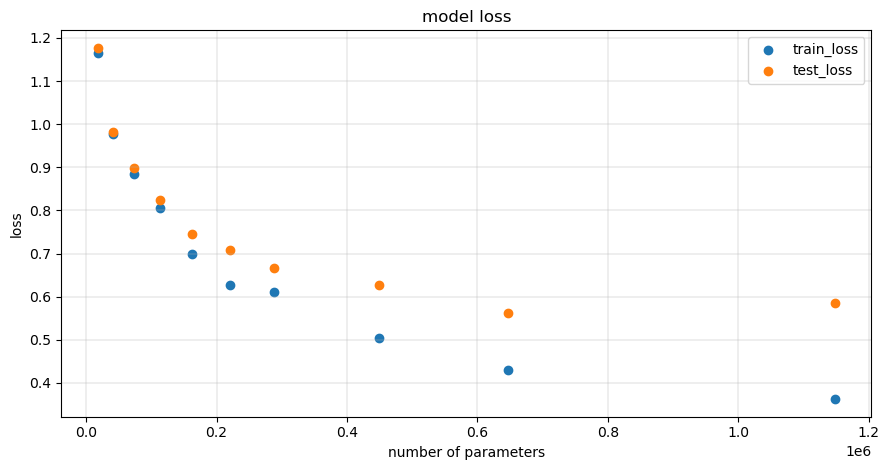

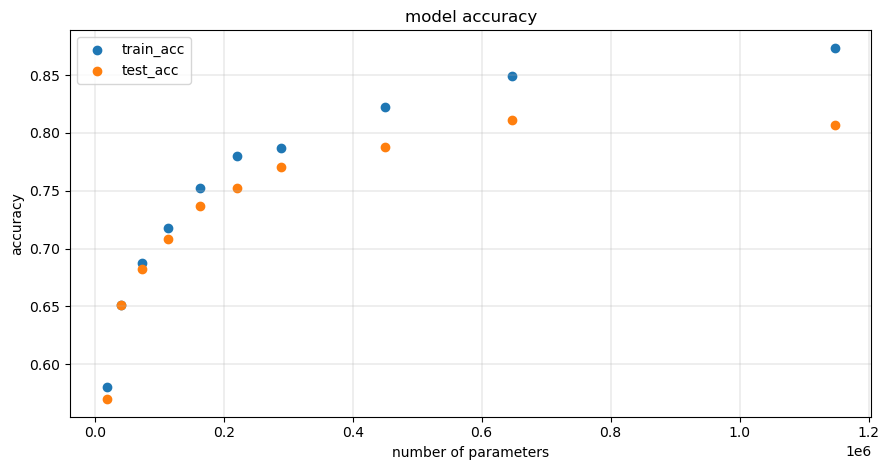

In [9]:
if __name__ == "__main__":
    main()